## imports

In [2]:
!pip install psynlig
!pip install scikit-plot
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scikitplot.helpers import binary_ks_curve
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, matthews_corrcoef, average_precision_score
from sklearn.metrics import log_loss, brier_score_loss, top_k_accuracy_score
from sklearn.metrics import brier_score_loss, jaccard_score
from sklearn.decomposition import PCA
from psynlig import pca_residual_variance
from imblearn.over_sampling import SMOTE 
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from sklearn.tree import export_graphviz
from scipy.stats import pearsonr
import graphviz
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## preprocessing of KDD dataset

In [3]:
df = pd.read_csv(r"../data/kddcup99.csv",index_col=0).reset_index(drop=True)
df = df.sample(n = 40000, random_state=31).reset_index(drop=True)
np.random.seed(42)
# change of decision variable classes by tagging 0 for normal and 1 for fraud ----just for kdd----
df.loc[(df.label !="normal"),"target"] = 1
df.loc[(df.label =="normal"),"target"] = 0
df = df.drop(['label'], axis=1)
feat_df = df.drop(['target'], axis=1)
label_df = df.target
# convert categorical features to binary
obj_df = feat_df.select_dtypes(include=['object']).copy()
categorical_df = pd.DataFrame()
for c in range(len(obj_df.columns)) :
    col = obj_df.columns[c]
    cat_df = pd.get_dummies(feat_df[col]).reset_index(drop=True) 
    cat_df = cat_df.iloc[:, :-1]
    categorical_df = pd.concat([categorical_df, cat_df], axis=1)    
features_df = feat_df.drop(obj_df.columns, axis=1)
features_df = pd.concat([features_df, categorical_df], axis=1) 
col_name = features_df.columns
df2 = features_df.copy()  
del categorical_df , obj_df
### normalizing
features_df = pd.DataFrame(scale(features_df))
features_df.columns = col_name
x_train, x_test, y_train, y_test = train_test_split(features_df, label_df, train_size = 0.7, random_state = 42)  
train_df = pd.concat([x_train, y_train], axis=1).reset_index(drop = True) 
test_df = pd.concat([x_test, y_test], axis=1).reset_index(drop = True)

## Residual variance -> Dimensionality Reduction with Principal Component Analysis

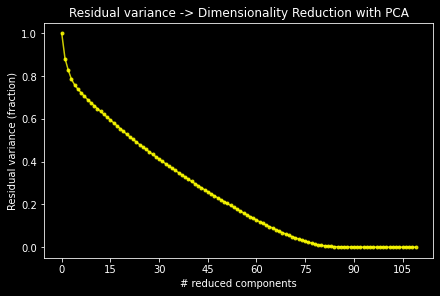

<Figure size 432x288 with 0 Axes>

In [4]:
plt.style.use('dark_background')
pca = PCA()
pca.fit_transform(x_train)
pca_residual_variance(pca, marker='o', markersize=3, color = "yellow", alpha=0.8)
plt.xlabel("# reduced components")
plt.title("Residual variance -> Dimensionality Reduction with PCA")
plt.show()
plt.clf()

## Pearson correlation

Features that have Pearson correlation > 0.8

In [5]:
def pearson_correlation():
    for i in range(len(df2.columns)):
        for j in range (i+1,len(df2.columns)):
            crr1 = df2[df2.columns[i]].tolist()
            crr2 = df2[df2.columns[j]].tolist()
            corr, _ = pearsonr(crr1, crr2)
            corr = abs(corr)
            if corr>=0.8:
                yield df2.columns[i]
                yield df2.columns[j]
                yield corr
                
high_correlation = []
for x in pearson_correlation():
    high_correlation.append(x)
feature_1 = []
feature_2 = []
correlation_coefficient = []
for i in range(int(len(high_correlation)/3)):
    feature_1.append(high_correlation[i*3])
    feature_2.append(high_correlation[i*3+1])
    correlation_coefficient.append(high_correlation[i*3+2])
prs_corr = pd.DataFrame({'feature 1' : feature_1 , 'feature 2' : feature_2 ,
                         'pearson correlation coefficient' : correlation_coefficient})
prs_corr = prs_corr.sort_values(by=['pearson correlation coefficient'], ascending=False)
print("\n")
print("---------------------------------------- Pearson correlation ----------------------------------------")
print(tabulate(prs_corr, headers = 'keys', tablefmt = 'psql'))



---------------------------------------- Pearson correlation ----------------------------------------
+----+-----------------------------+-----------------------------+-----------------------------------+
|    | feature 1                   | feature 2                   |   pearson correlation coefficient |
|----+-----------------------------+-----------------------------+-----------------------------------|
| 22 | srv_serror_rate             | dst_host_srv_serror_rate    |                          0.999578 |
| 16 | serror_rate                 | dst_host_serror_rate        |                          0.999025 |
| 23 | srv_serror_rate             | S0                          |                          0.998764 |
| 53 | dst_host_srv_serror_rate    | S0                          |                          0.998549 |
| 50 | dst_host_serror_rate        | dst_host_srv_serror_rate    |                          0.998239 |
| 13 | serror_rate                 | srv_serror_rate             |      

## Balance check

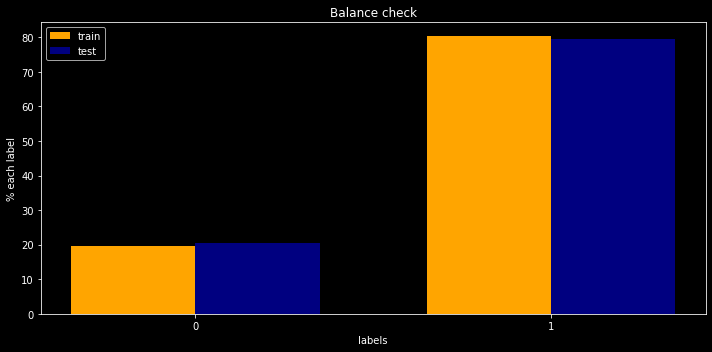



+----+---------+---------+
|    |   train |    test |
|----+---------+---------|
|  0 | 19.7214 | 20.3917 |
|  1 | 80.2786 | 79.6083 |
+----+---------+---------+


In [6]:
train_frauds = (sum(train_df.target)/len(train_df))*100
train_norms = 100 - train_frauds
test_frauds = (sum(test_df.target)/len(test_df))*100
test_norms = 100 - test_frauds
train_per = (train_norms, train_frauds)
test_per = (test_norms, test_frauds)
fig, ax = plt.subplots(figsize = (10, 5))
index = np.arange(2)
bar_width = 0.35
rects1 = plt.bar(index, train_per, bar_width, color='orange', label='train')
rects2 = plt.bar(index + bar_width, test_per, bar_width, color='navy',label='test')
plt.xlabel('labels')
plt.ylabel('% each label')
plt.title('Balance check')
plt.xticks(index + 0.5*bar_width, ('0', '1'))
plt.legend()
plt.tight_layout()
plt.show()
tr_ts_df = pd.DataFrame({'train' : train_per, 'test' : test_per})
print("\n")
print(tabulate(tr_ts_df, headers = 'keys', tablefmt = 'psql'))

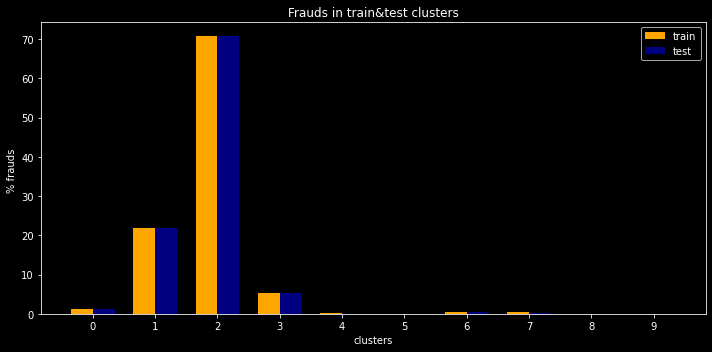

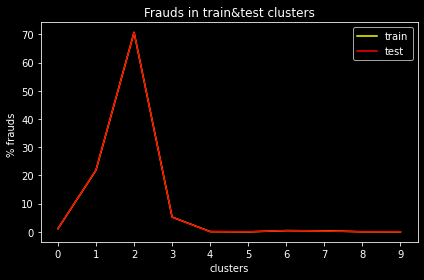



+----+------------------+----------------+
|    |   % train_frauds |   %test_frauds |
|----+------------------+----------------|
|  0 |        1.13444   |      1.13053   |
|  1 |       21.8881    |     21.9722    |
|  2 |       70.7536    |     70.7526    |
|  3 |        5.23178   |      5.21302   |
|  4 |        0.0978735 |      0.0732754 |
|  5 |        0.0133464 |      0.0209358 |
|  6 |        0.444879  |      0.471056  |
|  7 |        0.364801  |      0.314037  |
|  8 |        0.0444879 |      0.0209358 |
|  9 |        0.0266928 |      0.0314037 |
+----+------------------+----------------+


In [7]:
x_all = pd.concat([x_train, x_test], axis=0).reset_index(drop = True)
cluster = 10
data = np.array(x_all).reshape(-1, x_all.shape[1])
km = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
x_all['cluster_group'] = km.fit_predict(data).tolist()
train_df['cluster_group'] = x_all['cluster_group'][:len(x_train)].reset_index(drop = True)
test_df['cluster_group'] = x_all['cluster_group'][len(x_train):].reset_index(drop = True)
train_fraud = []
test_fraud = []
for i in range(cluster):
    df_1 = train_df[train_df['cluster_group']==i]
    train_fraud.append(100*sum(df_1.target)/sum(train_df.target))
for i in range(cluster):
    df_1 = test_df[test_df['cluster_group']==i]
    test_fraud.append(100*sum(df_1.target)/sum(test_df.target))
fig, ax = plt.subplots(figsize = (10, 5))
index = np.arange(10)
bar_width = 0.35
rects1 = plt.bar(index, train_fraud, bar_width, color='orange', label='train')
rects2 = plt.bar(index + bar_width, test_fraud, bar_width, color='navy',label='test')
plt.xlabel('clusters')
plt.ylabel('% frauds ')
plt.title('Frauds in train&test clusters')
plt.xticks(index + 0.5*bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
plt.legend()
plt.tight_layout()
plt.show()
plt.clf()
print("\n")
plt.plot(index, train_fraud, color = "yellow", label='train')
plt.plot(index, test_fraud, color = "red", label='test')
plt.xlabel('clusters')
plt.ylabel('% frauds ')
plt.title('Frauds in train&test clusters')
plt.xticks(index , ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
plt.legend()
plt.tight_layout()
plt.show()

tr_ts_df2 = pd.DataFrame({'% train_frauds' : train_fraud, '%test_frauds' : test_fraud})
print("\n")
print(tabulate(tr_ts_df2, headers = 'keys', tablefmt = 'psql'))

## Error analysis

unsupervised anomaly detection model : One-Class Support Vector Machines

train_step :

In [8]:
np.random.seed(31)
svm_model = svm.OneClassSVM()
svm_model.fit(x_train)
svm_pred = svm_model.predict(x_train)
svm_pred = pd.Series(svm_pred).replace([-1,1],[1,0])
svm_conf_mat = pd.DataFrame(confusion_matrix(y_train, svm_pred))
print('  confusion_matrix  ')
print(tabulate(svm_conf_mat, headers = 'keys', tablefmt = 'psql'))
index = []
test_score = [] 
tn, fp, fn, tp = confusion_matrix(y_train, svm_pred).ravel()
index.append("accuracy")
test_score.append((tp + tn) / (tp + fp + fn + tn))
index.append("recall_score")
test_score.append(recall_score(y_train, svm_pred)) 
index.append("precision_score")
test_score.append(precision_score(y_train, svm_pred))
index.append("f1_score")
test_score.append(f1_score(y_train, svm_pred)) 
index.append("f2_score")
test_score.append(fbeta_score(y_train, svm_pred, beta = 2))
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y_train, svm_pred))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y_train, svm_pred))
index.append("false_positive_rate")
test_score.append(fp / (fp + tn))
index.append("false_negative_rate")
test_score.append(fn / (tp + fn))
index.append("true_negative_rate")
test_score.append(tn / (tn + fp))
index.append("negative_predictive_value")
test_score.append(tn/ (tn + fn))
index.append("false_discovery_rate")
test_score.append(fp/ (tp + fp))
index.append("matthews_corr")
test_score.append(matthews_corrcoef(y_train, svm_pred))
index.append("avg_precision")
test_score.append(average_precision_score(y_train, svm_pred))
index.append("log_loss")
test_score.append(log_loss(y_train, svm_pred))
index.append("brier_score_loss")
test_score.append(brier_score_loss(y_train, svm_pred))
index.append("binary_ks_curve")
res = binary_ks_curve(y_train, svm_pred)
test_score.append(res[3])
from sklearn.metrics import balanced_accuracy_score
index.append("balanced_accuracy_score")
test_score.append(balanced_accuracy_score(y_train, svm_pred))
index.append("top_k_accuracy_score")
test_score.append(top_k_accuracy_score(y_train, svm_pred, k=2))
index.append("brier_score_loss")
test_score.append(brier_score_loss(y_train, svm_pred))
index.append("jaccard_score")
test_score.append(jaccard_score(y_train, svm_pred))
### summary scores in dataframe 
print("\n")
print('------------------- scores --------------------')
score_df1 = pd.DataFrame({"index":index ,"score" :test_score })
print(tabulate(score_df1, headers = 'keys', tablefmt = 'psql'))

y_df_train = pd.DataFrame(y_train).reset_index(drop = True)
y_df_train['pred_label'] = svm_pred
clusters = train_df.cluster_group.reset_index()
y_df_train['cluster_group'] = clusters.cluster_group
per_error_train = []
for j in range(cluster):
    df = y_df_train[y_df_train.cluster_group == j]
    fr_df = df[df.target == 1]
    real = max(len(fr_df.target) , 1)
    err = len(fr_df[fr_df.pred_label == 0])
    per_error_train.append(100*err/real)

  confusion_matrix  
+----+------+-------+
|    |    0 |     1 |
|----+------+-------|
|  0 |  790 |  4732 |
|  1 | 3546 | 18932 |
+----+------+-------+


------------------- scores --------------------
+----+---------------------------+------------+
|    | index                     |      score |
|----+---------------------------+------------|
|  0 | accuracy                  |  0.704357  |
|  1 | recall_score              |  0.842246  |
|  2 | precision_score           |  0.800034  |
|  3 | f1_score                  |  0.820597  |
|  4 | f2_score                  |  0.833451  |
|  5 | cohen_kappa_score         | -0.015985  |
|  6 | roc_auccuracy_score       |  0.492655  |
|  7 | false_positive_rate       |  0.856936  |
|  8 | false_negative_rate       |  0.157754  |
|  9 | true_negative_rate        |  0.143064  |
| 10 | negative_predictive_value |  0.182196  |
| 11 | false_discovery_rate      |  0.199966  |
| 12 | matthews_corr             | -0.0161571 |
| 13 | avg_precision         

test step

In [9]:
svm_pred_test = svm_model.predict(x_test)
svm_pred_test = pd.Series(svm_pred_test).replace([-1,1],[1,0])
svm_conf_mat_test = pd.DataFrame(confusion_matrix(y_test, svm_pred_test))
print('  confusion_matrix  ')
print(tabulate(svm_conf_mat_test, headers = 'keys', tablefmt = 'psql'))
index = []
test_score = [] 
tn, fp, fn, tp = confusion_matrix(y_test, svm_pred_test).ravel()
index.append("accuracy")
test_score.append((tp + tn) / (tp + fp + fn + tn))
index.append("recall_score")
test_score.append(recall_score(y_test, svm_pred_test)) 
index.append("precision_score")
test_score.append(precision_score(y_test, svm_pred_test))
index.append("f1_score")
test_score.append(f1_score(y_test, svm_pred_test)) 
index.append("f2_score")
test_score.append(fbeta_score(y_test, svm_pred_test, beta = 2))
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y_test, svm_pred_test))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y_test, svm_pred_test))
index.append("false_positive_rate")
test_score.append(fp / (fp + tn))
index.append("false_negative_rate")
test_score.append(fn / (tp + fn))
index.append("true_negative_rate")
test_score.append(tn / (tn + fp))
index.append("negative_predictive_value")
test_score.append(tn/ (tn + fn))
index.append("false_discovery_rate")
test_score.append(fp/ (tp + fp))
index.append("matthews_corr")
test_score.append(matthews_corrcoef(y_test, svm_pred_test))
index.append("avg_precision")
test_score.append(average_precision_score(y_test, svm_pred_test))
index.append("log_loss")
test_score.append(log_loss(y_test, svm_pred_test))
index.append("brier_score_loss")
test_score.append(brier_score_loss(y_test, svm_pred_test))
index.append("binary_ks_curve")
res = binary_ks_curve(y_test, svm_pred_test)
test_score.append(res[3])
from sklearn.metrics import balanced_accuracy_score
index.append("balanced_accuracy_score")
test_score.append(balanced_accuracy_score(y_test, svm_pred_test))
index.append("top_k_accuracy_score")
test_score.append(top_k_accuracy_score(y_test, svm_pred_test, k=2))
index.append("brier_score_loss")
test_score.append(brier_score_loss(y_test, svm_pred_test))
index.append("jaccard_score")
test_score.append(jaccard_score(y_test, svm_pred_test))
### summary scores in dataframe 
print("\n")
print('------------------- scores --------------------')
score_df2 = pd.DataFrame({"index":index ,"score" :test_score })
print(tabulate(score_df2, headers = 'keys', tablefmt = 'psql'))
y_df_test = pd.DataFrame(y_test).reset_index(drop = True)
y_df_test['pred_label'] = svm_pred_test
clusters = test_df.cluster_group.reset_index()
y_df_test['cluster_group'] = clusters.cluster_group
per_error_tset = []
for j in range(cluster):
    df = y_df_test[y_df_test.cluster_group == j]
    fr_df = df[df.target == 1]
    real = max(len(fr_df.target) , 1)
    err = len(fr_df[fr_df.pred_label == 0])
    per_error_tset.append(100*err/real)

  confusion_matrix  
+----+------+------+
|    |    0 |    1 |
|----+------+------|
|  0 |  353 | 2094 |
|  1 | 1445 | 8108 |
+----+------+------+


------------------- scores --------------------
+----+---------------------------+-------------+
|    | index                     |       score |
|----+---------------------------+-------------|
|  0 | accuracy                  |  0.705083   |
|  1 | recall_score              |  0.848739   |
|  2 | precision_score           |  0.794746   |
|  3 | f1_score                  |  0.820855   |
|  4 | f2_score                  |  0.837361   |
|  5 | cohen_kappa_score         | -0.00776952 |
|  6 | roc_auccuracy_score       |  0.496498   |
|  7 | false_positive_rate       |  0.855742   |
|  8 | false_negative_rate       |  0.151261   |
|  9 | true_negative_rate        |  0.144258   |
| 10 | negative_predictive_value |  0.196329   |
| 11 | false_discovery_rate      |  0.205254   |
| 12 | matthews_corr             | -0.0079057  |
| 13 | avg_precisio

Display "% False Negative /  all_real_fraud" in each *cluster*

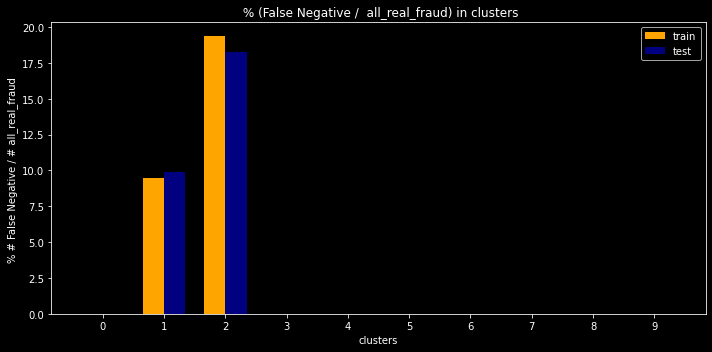



+----+----------+----------+
|    |    train |     test |
|----+----------+----------|
|  0 |  0       |  0       |
|  1 |  9.47154 |  9.90948 |
|  2 | 19.3662  | 18.3015  |
|  3 |  0       |  0       |
|  4 |  0       |  0       |
|  5 |  0       |  0       |
|  6 |  0       |  0       |
|  7 |  0       |  0       |
|  8 |  0       |  0       |
|  9 |  0       |  0       |
+----+----------+----------+


In [10]:
fig, ax = plt.subplots(figsize = (10, 5))
index = np.arange(10)
bar_width = 0.35
rects1 = plt.bar(index, per_error_train, bar_width, color='orange', label='train')
rects2 = plt.bar(index + bar_width, per_error_tset, bar_width, color='navy',label='test')
plt.xlabel('clusters')
plt.ylabel('% # False Negative / # all_real_fraud ')
plt.title(' % (False Negative /  all_real_fraud) in clusters')
plt.xticks(index + 0.5*bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
plt.legend()
plt.tight_layout()
plt.show()
print("\n")
df_fn = pd.DataFrame({'train' : per_error_train, 'test' : per_error_tset})
print(tabulate(df_fn, headers = 'keys', tablefmt = 'psql'))

## Decision tree for error analysis

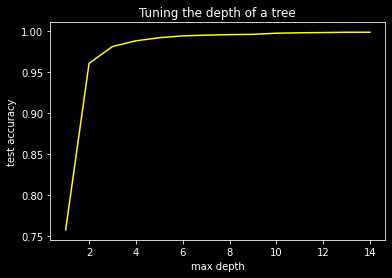



------- Tuned model scores : -------
Training set accuracy: 0.994
Test set accuracy: 0.994
------------------------------------

------------ Feature Importance ------------
+----+------------------------+--------------+
|    | feature                |   importance |
|----+------------------------+--------------|
| 19 | srv_count              |        0.877 |
| 18 | count                  |        0.075 |
| 24 | same_srv_rate          |        0.027 |
| 35 | dst_host_rerror_rate   |        0.008 |
| 29 | dst_host_same_srv_rate |        0.005 |
| 30 | dst_host_diff_srv_rate |        0.004 |
| 52 | ecr_i                  |        0.002 |
| 20 | serror_rate            |        0.002 |
| 63 | iso_tsap               |        0     |
| 82 | printer                |        0     |
| 81 | pop_3                  |        0     |
| 61 | http_443               |        0     |
| 80 | pop_2                  |        0     |
| 79 | pm_dump                |        0     |
| 62 | imap4             

In [11]:
train_df =  pd.concat([x_train.reset_index(drop =True), y_train.reset_index(drop =True)], axis=1)
svm_df_train = pd.DataFrame(svm_pred, columns = ['pred_label']).reset_index(drop =True)
train_df = pd.concat([train_df, svm_df_train], axis=1)
test_df =  pd.concat([x_test.reset_index(drop =True), y_test.reset_index(drop =True)], axis=1)
svm_df_test = pd.DataFrame(svm_pred_test, columns = ['pred_label']).reset_index(drop =True)
test_df = pd.concat([test_df, svm_df_test], axis=1)
new_df = pd.concat([train_df, test_df], axis=0).reset_index(drop =True)
new_df['fn_error'] = None
for r in range(len(new_df)) :
    if ((new_df.target[r] == 1) and (new_df.pred_label[r] == 0)) :
        new_df.fn_error[r] = 1
    else :
        new_df.fn_error[r] = 0
dt_df = new_df.drop(['target', 'pred_label'], axis=1)
### 
x_new = dt_df.drop(['fn_error'], axis=1)
y_new = dt_df.fn_error.astype('int')
sm = SMOTE(random_state=42)
x_blnc, y_blnc = sm.fit_resample(x_new, y_new)
x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(x_blnc, y_blnc, train_size = 0.7, random_state = 42)
# List of values to try for max_depth:
max_depth_range = list(range(1, 15))
# List to store the accuracy for each value of max_depth:
test_accuracy = []
for depth in max_depth_range:
    
    dt_clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    dt_clf.fit(x_train_dt, y_train_dt)
    score = dt_clf.score(x_test_dt, y_test_dt)
    test_accuracy.append(score)

fig = plt.figure()
ax = plt.axes()
plt.plot(max_depth_range, test_accuracy, color = "yellow")
plt.xlabel("max depth")
plt.ylabel("test accuracy")
plt.title("Tuning the depth of a tree")
plt.show()
dt_clf = DecisionTreeClassifier(max_depth = 6, random_state = 0)
dt_clf.fit(x_train_dt, y_train_dt)
print("\n")
print("------- Tuned model scores : -------")
print("Training set accuracy: {:.3f}".format(dt_clf.score(x_train_dt, y_train_dt)))
print("Test set accuracy: {:.3f}".format(dt_clf.score(x_test_dt, y_test_dt)))
print("------------------------------------\n")
print("------------ Feature Importance ------------")
importances = pd.DataFrame({'feature':x_train_dt.columns,'importance':np.round(dt_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print(tabulate(importances.iloc[:15, :], headers = 'keys', tablefmt = 'psql'))


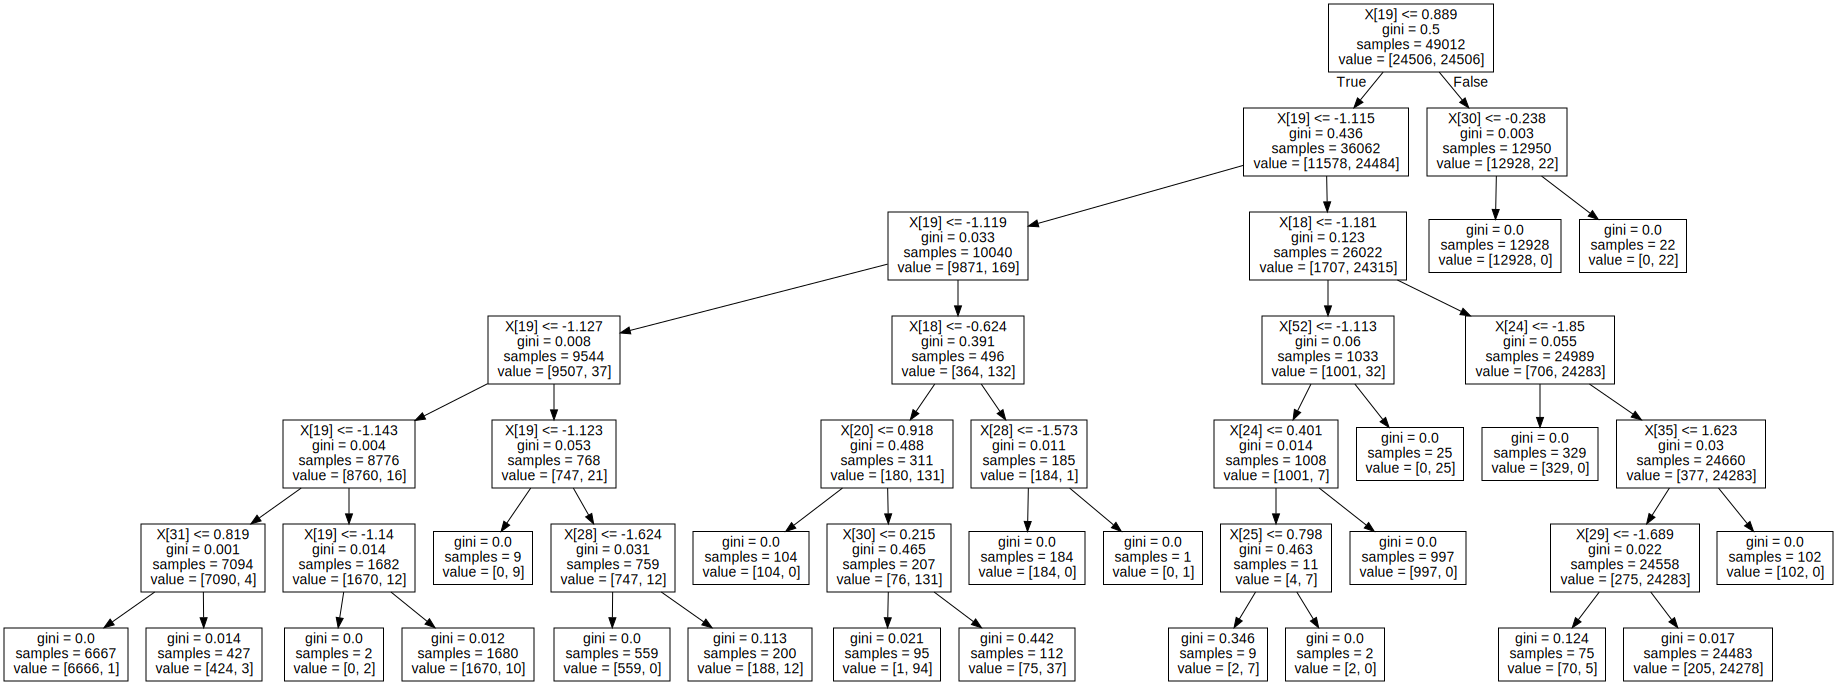

In [12]:
### show the tree
export_graphviz(dt_clf,out_file="tree.dot")
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [12]:
fn = df2.columns.tolist()

In [ ]:
import sklearn
def tree_to_df(reg_tree, feature_names):
    tree_ = reg_tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, row, ret):
        if tree_.feature[node] != sklearn.tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Add rule to row and search left branch
            row[-1].append(name + " <= " +  str(round(threshold,3)))
            recurse(tree_.children_left[node], row, ret)
            # Add rule to row and search right branch
            row[-1].append(name + " > " +  str(round(threshold,3)))
            recurse(tree_.children_right[node], row, ret)
        else:
            # Add output rules and start a new row
            label = tree_.value[node]
            ret.append("Value: [" + str(label[0][0]) + ',' + str(label[0][1]) + "]")
            row.append([])
    
    # Initialize
    rules = [[]]
    vals = []
    
    # Call recursive function with initial values
    recurse(0, rules, vals)
    
    # Convert to table and output
    df_tree = pd.DataFrame(rules).dropna(how='all')
    df_tree['Return'] = pd.Series(vals)
    columns = []
    for i in range(6):
        columns.append(f"Depth {i}")
    columns.append('Values')
    df_tree.columns = columns
    return df_tree

tree_to_df(dt_clf , fn)